# Project: Concrete Strength Prediction
# Name: Jinad Patel
# Email: Jinadpatel@gmail.com
# GitHub URL: TODO

### Objective
To predict the concrete strength using the data available in file concrete_data.xls. Apply
feature engineering and model tuning to obtain 80% to 95% of R2score.

### Resources Available
The data for this project is available in file https://archive.ics.uci.edu/ml/machine-learningdatabases/concrete/compressive/. The same has been shared along with the course content.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import required libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Skelearn libraries
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

# Regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge # Linear Regression model
from sklearn.tree import DecisionTreeRegressor # Decision tree regressor

# Ensemble regressor models
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor

# Cross Validation
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV

# Score calculators
from sklearn.utils import resample # Used to find the bootstrapping confidence interval

# Scoring mertics
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix, explained_variance_score, r2_score
# Pipeline for ease in model building
from sklearn.pipeline import Pipeline
# Imaging tools
from IPython.display import Image
from sklearn import tree
from scipy.stats import randint as sp_randint
from os import system

sns.set_color_codes("dark")

In [3]:
# Adjust pandas display and formatting settings

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format        

# Increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Update default style and size of charts
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 15]

# Increase max number of rows and columns to display in pandas tables
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500)
SEED=42
NUM_FOLDS=10

## Exploratory Data Analysis

In [4]:
df = pd.read_csv('concrete.csv')
print(df.shape)

(1030, 9)


In [5]:
# Check the head and shape of the data
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,23.51
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,45.85
4,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28,18.29


In [6]:
# Check info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


* We have around 1000 data points and 9 columns. All the columns are having numerical values.

### STEP 1: Univariate Analysis
* data types and description of the independent attributes
which should include (name, meaning, range of values observed, central values
(mean and median), standard deviation and quartiles, analysis of the body of
distributions / tails, missing values, outliers (10 Marks)

In [7]:
# Five point summary and heatmap of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,"1,030.00",281.17,104.51,102.00,192.38,272.90,350.00,540.00
slag,"1,030.00",73.90,86.28,0.00,0.00,22.00,142.95,359.40
ash,"1,030.00",54.19,64.00,0.00,0.00,0.00,118.30,200.10
water,"1,030.00",181.57,21.35,121.80,164.90,185.00,192.00,247.00
superplastic,"1,030.00",6.20,5.97,0.00,0.00,6.40,10.20,32.20
coarseagg,"1,030.00",972.92,77.75,801.00,932.00,968.00,"1,029.40","1,145.00"
fineagg,"1,030.00",773.58,80.18,594.00,730.95,779.50,824.00,992.60
age,"1,030.00",45.66,63.17,1.00,7.00,28.00,56.00,365.00
strength,"1,030.00",35.82,16.71,2.33,23.71,34.45,46.14,82.60


#### Five point summary observations
* 'cement': min-102, max-540. Standar deviation is high. Also mean-281.17 and median 272.90 is differing, representing some level of skewness in the data.
* 'slag': min-0, max-359.40. Mean-73.90 and median-22.00 represents high skewness. Standard deviation is 86.28. 1st quartile(25%) has 0 data points.
* 'ash': min-0, max-200.10. Standard deviation in 64.00. Mean-54.19 and median-0 represents skewness in the data. Until 2nd quartile(50%) the data is 0!
* 'water': min-121.80, max-247.00. Mean-181.57 and median-185.00. Standard deviation is 21.35. Distribution looks fairly normal. 3rd quartile(75%) has almost 192 data points.
* 'superplastic': min-0,max-32.30. Mean-6.20 and Median-6.40 also standard deviation (std) is 5.97 which is very low. Data is fairly distributed. 1st quartile(25%) 0 data points found. 
* 'coarseagg': Min-801.00, Max-1145. Mean-972.92 and median-968 also std is 77.75 which is quite high. Up to 2nd quartile, 968 data points are recorded.
* 'fineagg': Min-594.00 and max is 992. Mean-773.58 and Median 779.50 also std is 80.18 which denotes fair distribution of data. Also, 3rd Quartile (75%) has 824 records.
* 'age': Min-1, Max-365. Denotes number of days. Mean is 45.66 and median is 28 which is highly skewed. Also std is 63.17. There are records upto 56 days until 3rd quartile (75%). High skewness observed.
* 'strength': min-2.33 and max-82.60. Mean is 35.82 and median is 34.45 also std is 16.71 which is low and denotes fair data distribution. Upto 75% (3rd quartile) almost 47 points are recorded.

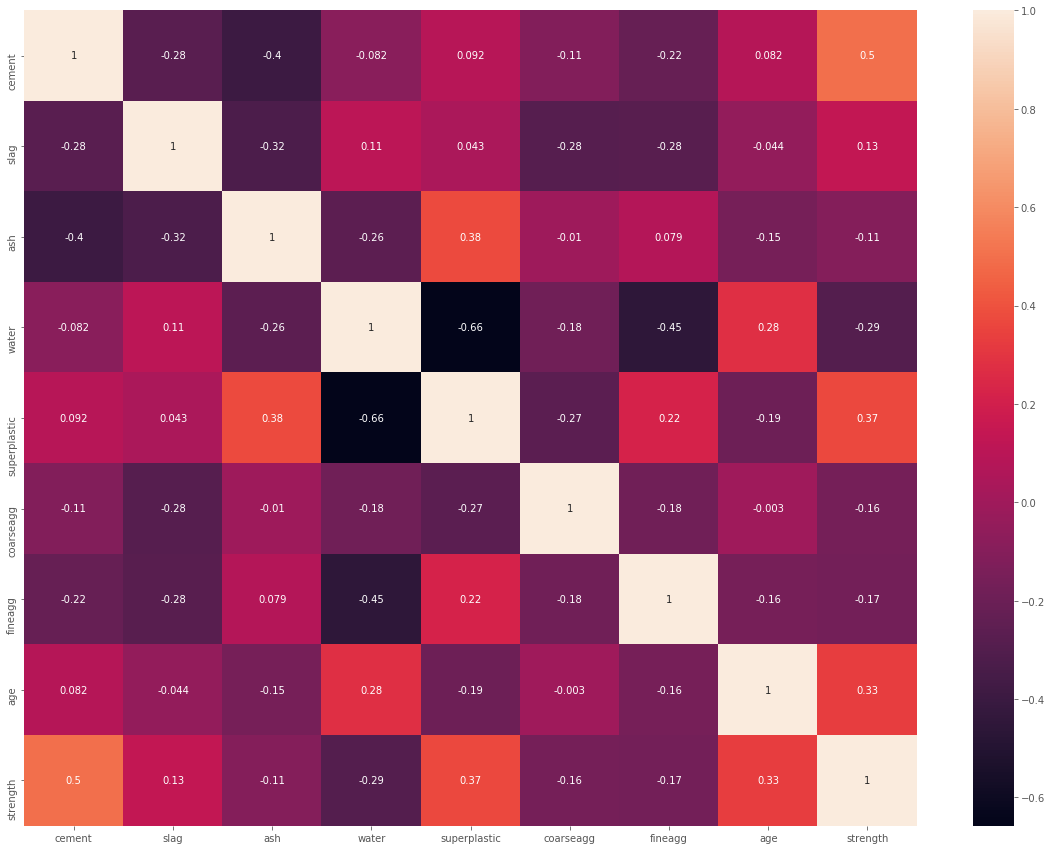

In [8]:
# Heatmap
sns.heatmap(df.corr(), annot=True)

#### Heatmap observations
* 'superplastic'and 'ash' are correlated at some extent
* 'strength' and 'cement' are also highly correlated. 'strength' is somewhat correlated with 'superplastic' and 'age'

In [9]:
# Check the data for any null values
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

* No null values are present in the data.

In [10]:
# Check for duplicate values
df[df.duplicated(keep='last')]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
27,425.00,106.30,0.00,153.50,16.50,852.10,887.10,91,65.20
49,425.00,106.30,0.00,153.50,16.50,852.10,887.10,3,33.40
88,362.60,189.00,0.00,164.90,11.60,944.70,755.80,3,35.30
91,362.60,189.00,0.00,164.90,11.60,944.70,755.80,7,55.90
96,362.60,189.00,0.00,164.90,11.60,944.70,755.80,28,71.30
190,362.60,189.00,0.00,164.90,11.60,944.70,755.80,56,77.30
245,362.60,189.00,0.00,164.90,11.60,944.70,755.80,91,79.30
278,425.00,106.30,0.00,153.50,16.50,852.10,887.10,3,33.40
333,252.00,0.00,0.00,185.00,0.00,"1,111.00",784.00,28,19.69
392,425.00,106.30,0.00,153.50,16.50,852.10,887.10,7,49.20


In [11]:
df.drop_duplicates(subset=None,keep='first',inplace=True)

In [12]:
df[df.duplicated(keep="last")]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength


In [13]:
df.shape

(1005, 9)

* Number of data points are reduced from 1030 to 1005 after treating duplicates.

### STEP 2: BiVariate & Multivariate Analysis
Bi-variate analysis between the predictor variables and between the predictor
variables and target column. Comment on your findings in terms of their
relationship and degree of relation if any. Visualize the analysis using boxplots and
pair plots, histograms or density curves. (10 marks)

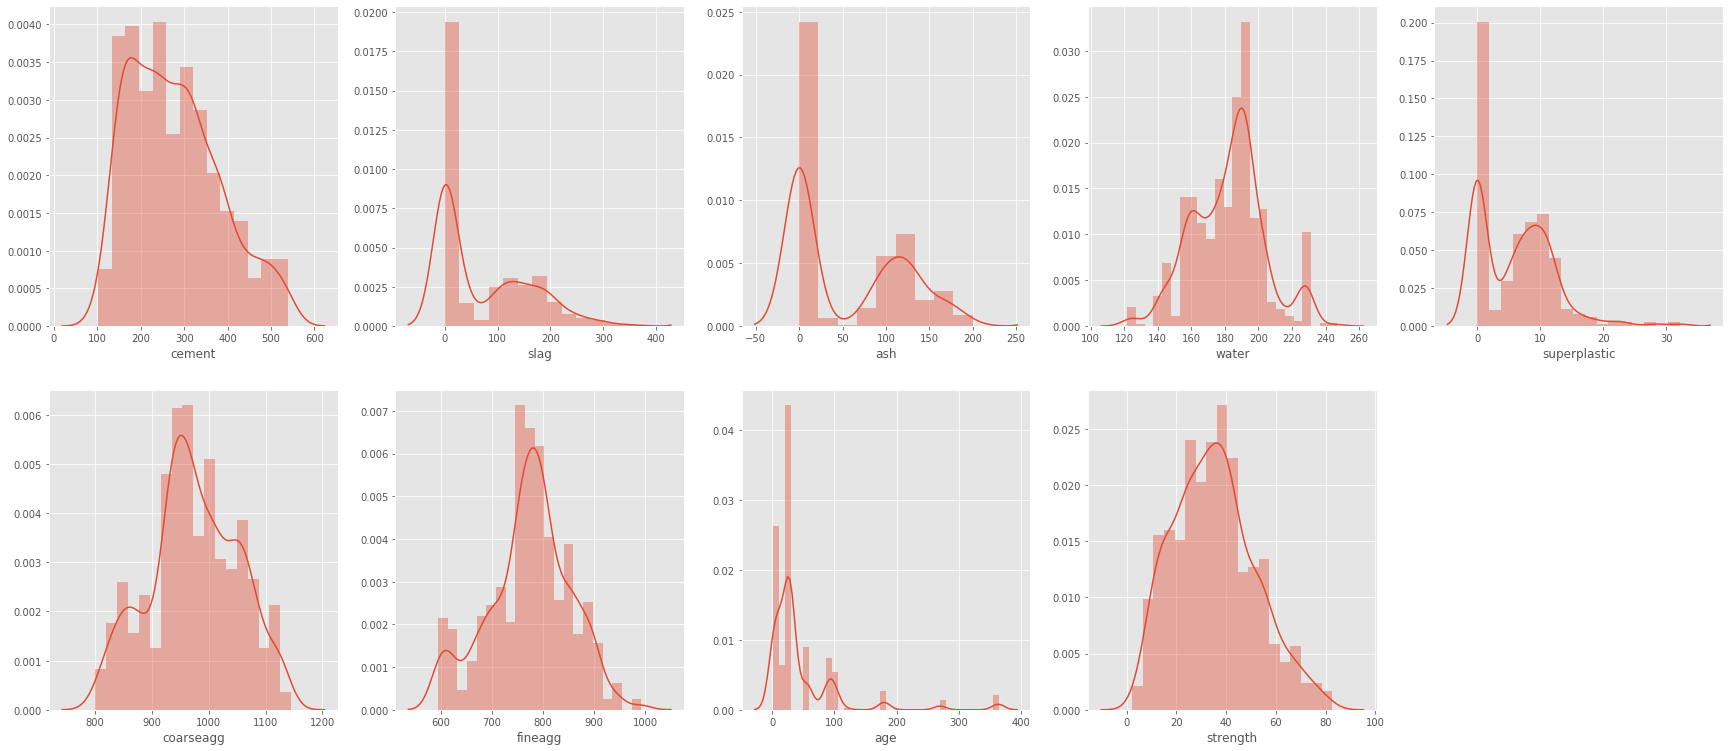

In [14]:
plt.figure(figsize= (30,20))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
for i in df.columns:
    plt.subplot(3, 5, pos)
    sns.distplot(df[i])  # Remove legend to make the entire plot look 'good'
    pos += 1

#### Observations from the distplots
* 'coarseagg' is fairly distributed.
* 'fineagg' is fairly distributed.
* 'slag' is highly positively skewed.
* 'water' has sligt negative skewness.
* 'ash' is highly positively skewed.
* 'superplastic' is also positively skewed.
* 'age' is also highly positively skewed.

The above observations match with our five point summary.

In [15]:
# Check the skewness to support visualization
df.skew().sort_values(ascending=False)

age             3.25
superplastic    0.98
slag            0.86
cement          0.56
ash             0.50
strength        0.40
water           0.03
coarseagg      -0.07
fineagg        -0.25
dtype: float64

* As noted here, our visualization supports the skewnes here.
* 'age' is highly skewed.
* 'superplastic' and 'slag' is hoghly skewed as well.
* 'coarseagg', 'fineagg', 'water' looks normally distributed.

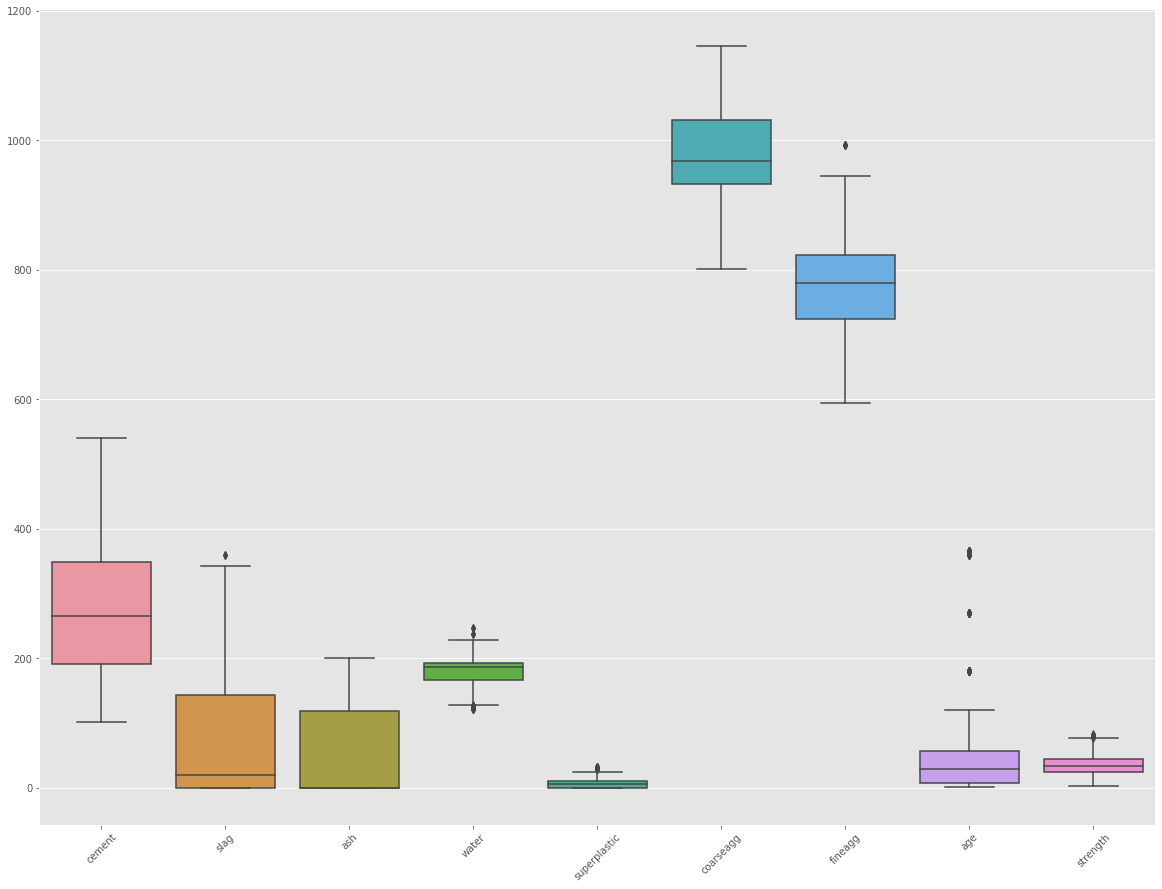

In [16]:
# Check outliers
box_plt = sns.boxplot(data=df)
box_plt.set_xticklabels(labels=box_plt.get_xticklabels(),rotation=45);

### Observations from box plots
* Outliers present for 'slag','water','superplastic','fineaagg','age'.
* 'water' has outliers for both lower and upper quartile ranges.
* 'age' has hihgest number of outliers and also very highly skewed as we seen in the visualization.


In [17]:
# Treat outliers
for col in df.columns.tolist():
    df[col].replace(df.loc[(df[col] > df[col].quantile(.75)+1.5*(df[col].quantile(.75)-df[col].quantile(.25)))|(df[col] < df[col].quantile(.25)-1.5*(df[col].quantile(.75)-df[col].quantile(.25))), col], df[col].median(), inplace=True)

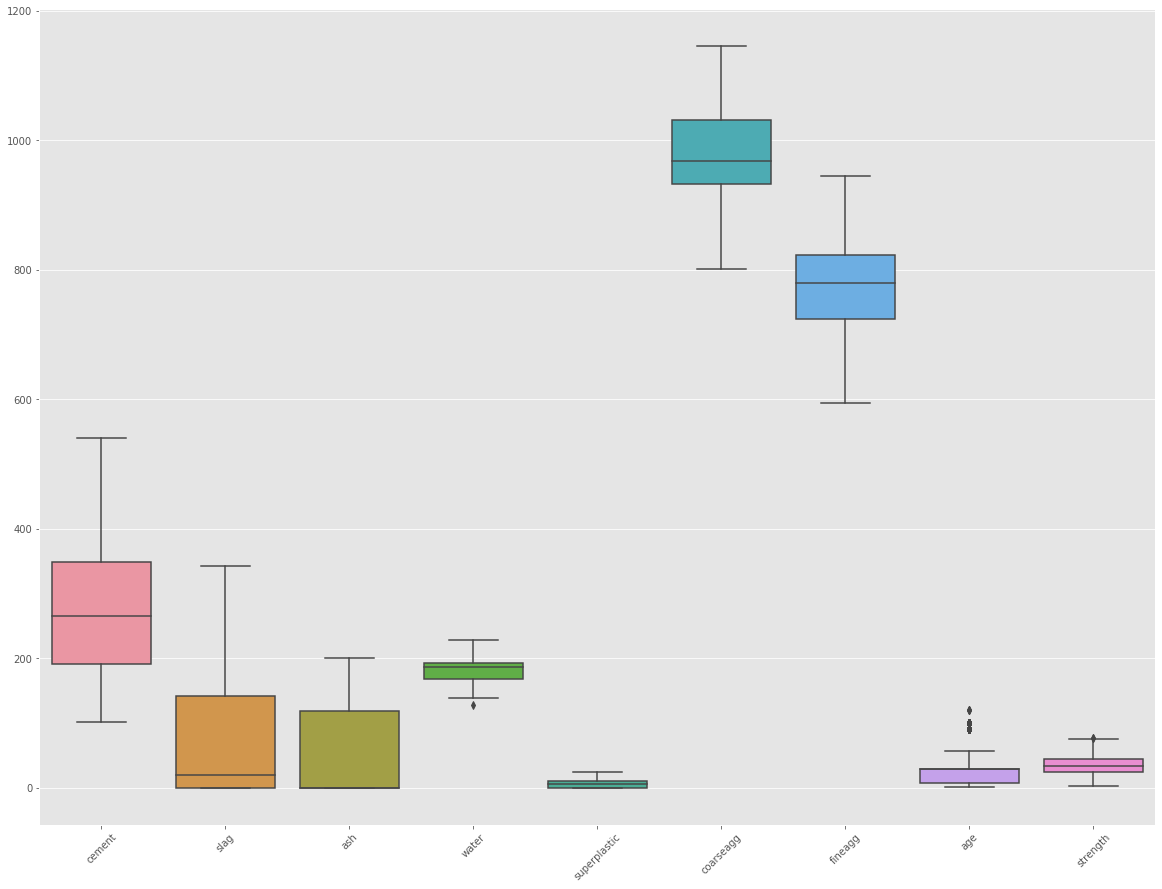

In [18]:
box_plt = sns.boxplot(data=df)
box_plt.set_xticklabels(labels=box_plt.get_xticklabels(),rotation=45);

#### Observations from outliers treatment
* As seen above, we have treated the outliers with the median value of that respective column.
* After the treatment, we see greatu number of reduced outliers in the 'age' and also in the 'water'.

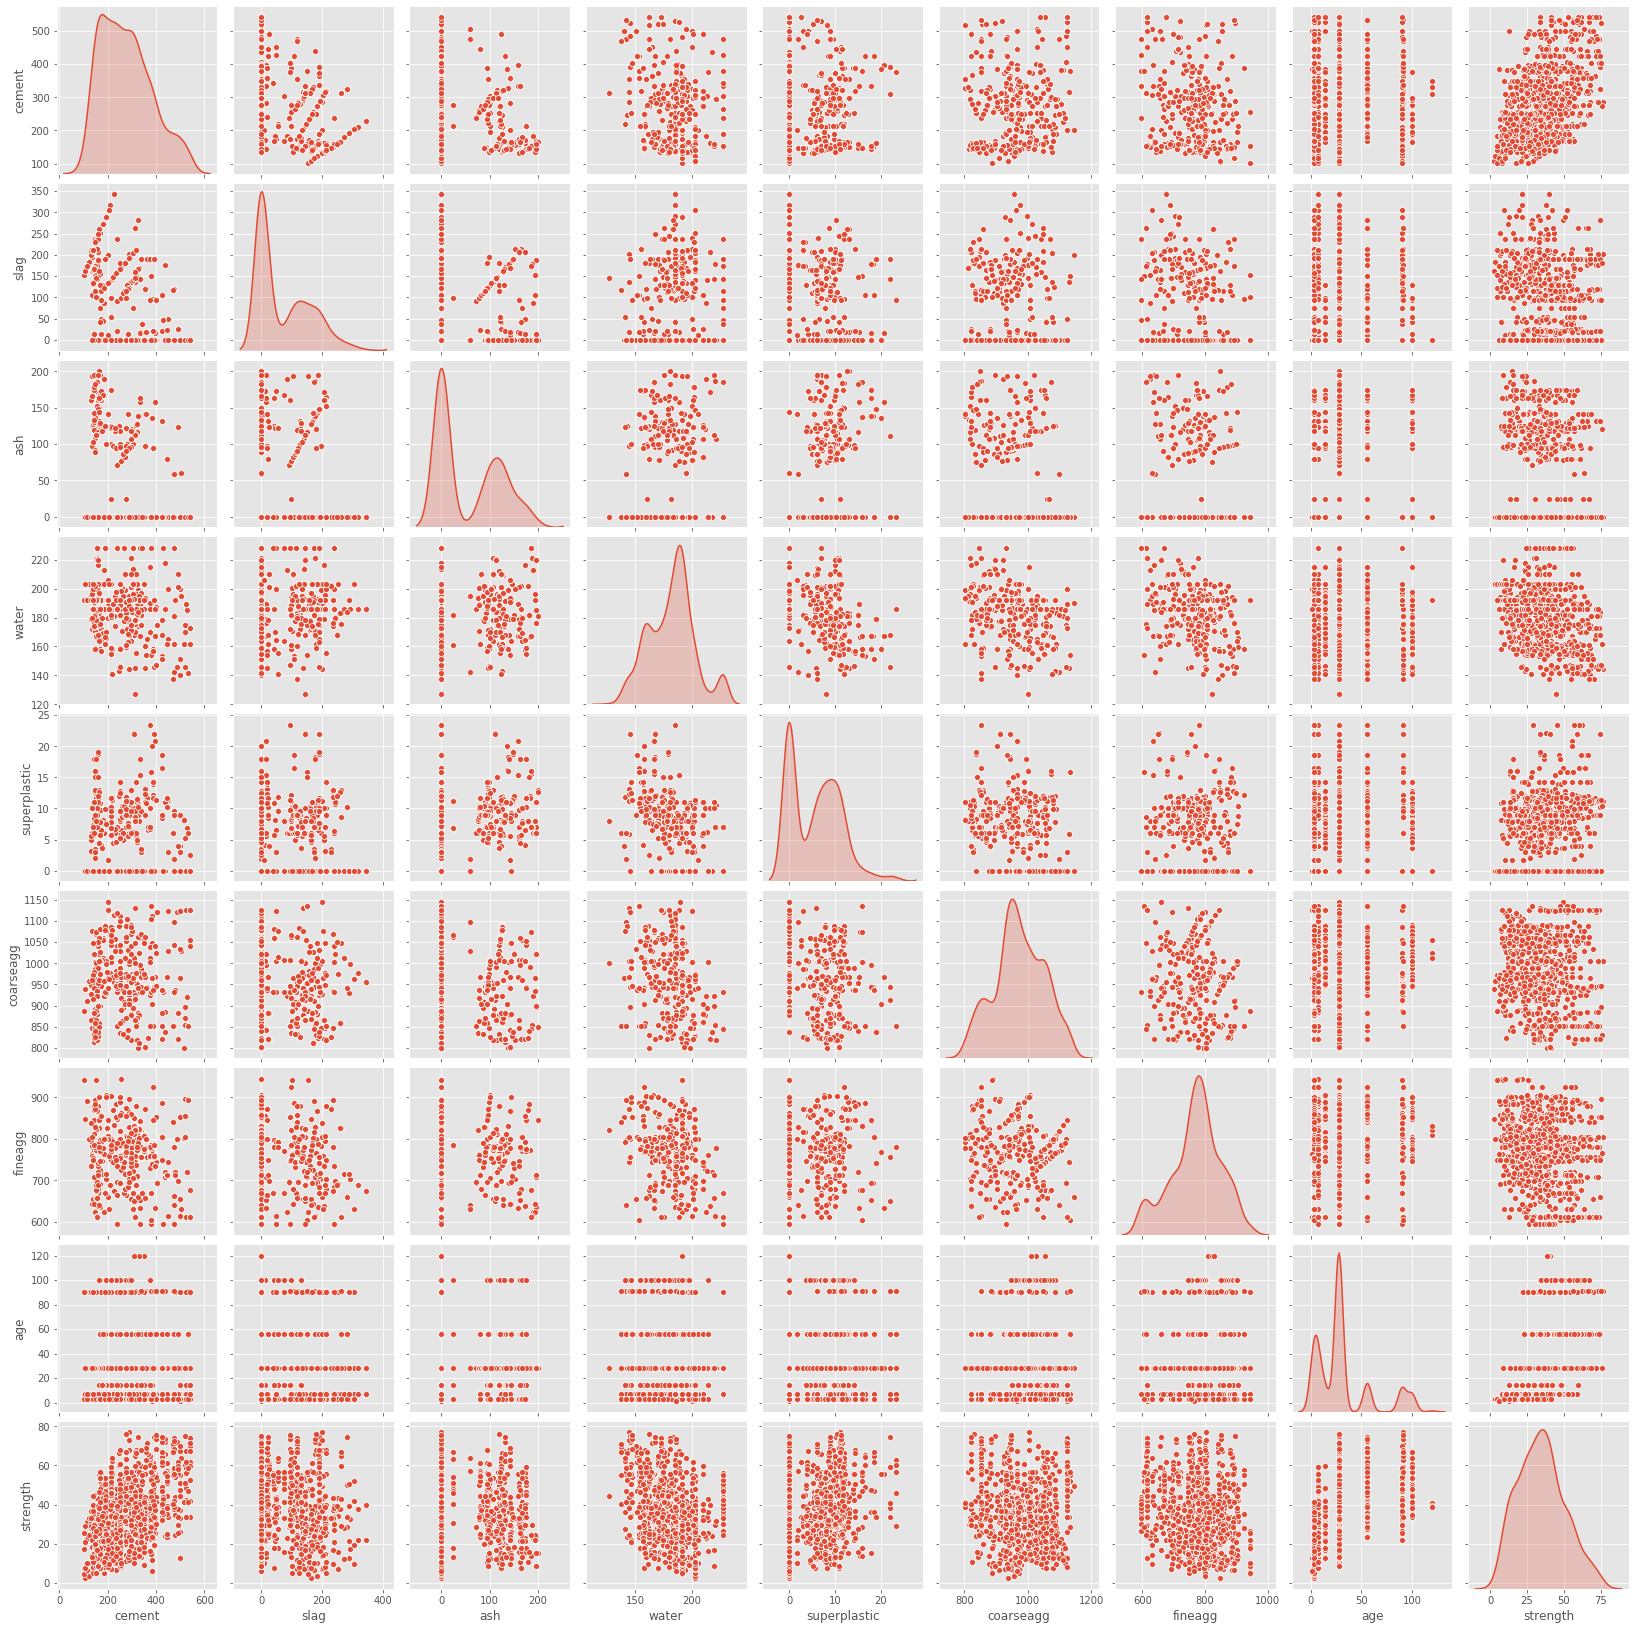

In [19]:
# Observe pairplot of the data
sns.pairplot(df, diag_kind='kde')

#### Observations from the above pairplot
* We have already discussed gaussian analysis on the top with displots. I will skip those analysis here.
* 'strength' is our target column. Hence, the below analysis is done across independent columns except strength.
* 'cement': No relationships found with other independent features. The data points are sperad all over as shown above.
* 'slag': No significant relationships found. It is scattered randomly.
* 'ash': No significant relationships found. Highly scattered.
* 'water': No relationships found. There is some negative correlation instead.
* 'superplastic': Found some correlation with ash. 'strength' and 'superplastic' has good correlation. No other significant correlations.
* 'coarseagg': No correlation found with other features. 
* 'fineagg': No correlation found. Scattered all over.
* 'age': Highly skewed and no correlation at all. 
* 'strength': Target column. It is correleated with 'cement' and 'superplastic'. More analysis will be done below.

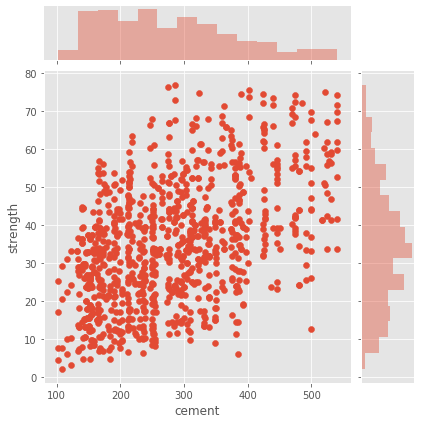

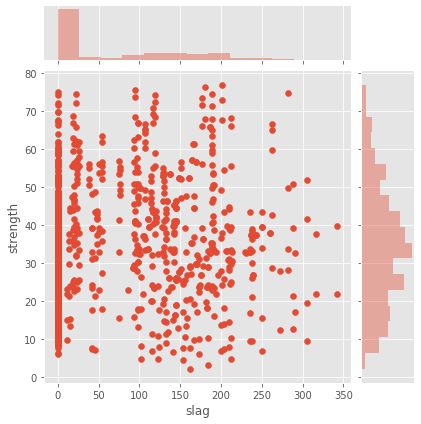

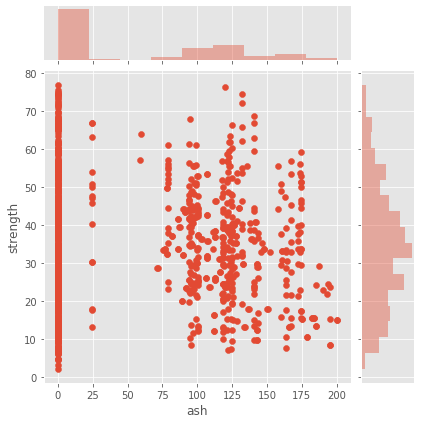

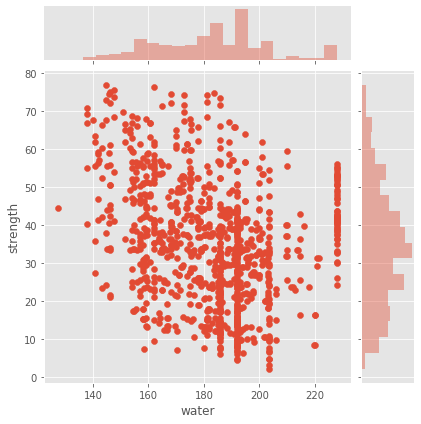

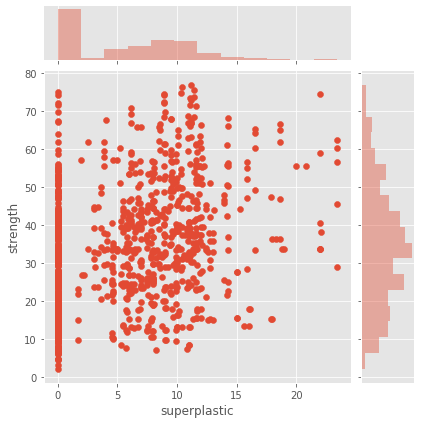

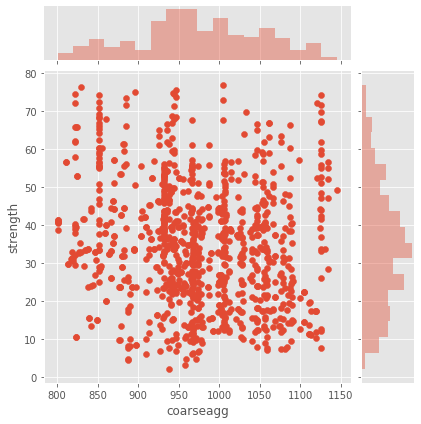

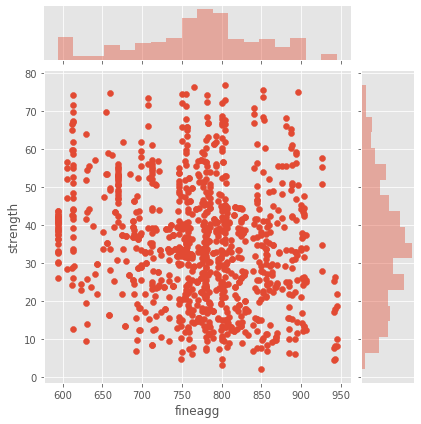

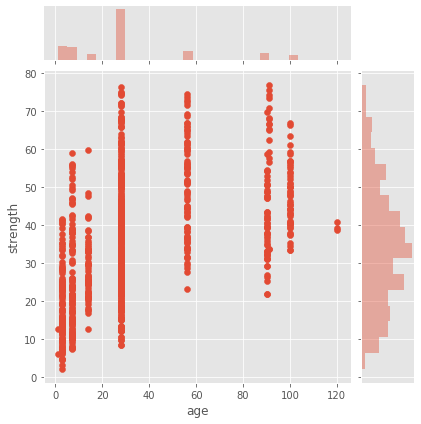

In [20]:
# Analysis of the independent with dependent cols
for col in df.columns.to_list():
    if col != 'strength':
        sns.jointplot(df[col],df['strength'])

#### Observations from Bivariate analysis
* We get very similar result to what we had done above with correlation and heatmap.
* 'strength' is...
    * Positively correlated with 'cement'
    * Negatively correlated with 'water'
    * Negatively correlated with 'coarseagg' and 'fineagg'
    * Slightly positively correlated with 'superplastic'

### STEP 3: Feature Engineering Techniques


* As we have seen above that 'cement' has good positive correlation with 'strength' and negative correlation with 'water', we can use their ratio to compare it with the strength.

In [21]:
df_mod=df.copy()
df_mod.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,23.51
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,45.85
4,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28,18.29


In [22]:
df_mod['cement_water_ratio'] = (df_mod['cement']/df_mod['water'])

In [23]:
df_mod.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cement_water_ratio
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89,0.69
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,23.51,1.07
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22,1.33
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,45.85,1.17
4,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28,18.29,0.80


In [24]:
# See the correlation 
df_mod.corr()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cement_water_ratio
cement,1.00,-0.30,-0.39,-0.05,-0.03,-0.09,-0.26,-0.04,0.48,0.95
slag,-0.30,1.00,-0.31,0.13,0.03,-0.28,-0.29,-0.04,0.09,-0.29
ash,-0.39,-0.31,1.00,-0.30,0.49,-0.03,0.10,0.06,-0.06,-0.29
water,-0.05,0.13,-0.30,1.00,-0.61,-0.21,-0.43,-0.03,-0.26,-0.35
superplastic,-0.03,0.03,0.49,-0.61,1.00,-0.20,0.14,0.06,0.30,0.16
coarseagg,-0.09,-0.28,-0.03,-0.21,-0.20,1.00,-0.14,0.02,-0.15,-0.05
fineagg,-0.26,-0.29,0.10,-0.43,0.14,-0.14,1.00,0.05,-0.20,-0.11
age,-0.04,-0.04,0.06,-0.03,0.06,0.02,0.05,1.00,0.50,-0.03
strength,0.48,0.09,-0.06,-0.26,0.30,-0.15,-0.20,0.50,1.00,0.53
cement_water_ratio,0.95,-0.29,-0.29,-0.35,0.16,-0.05,-0.11,-0.03,0.53,1.00


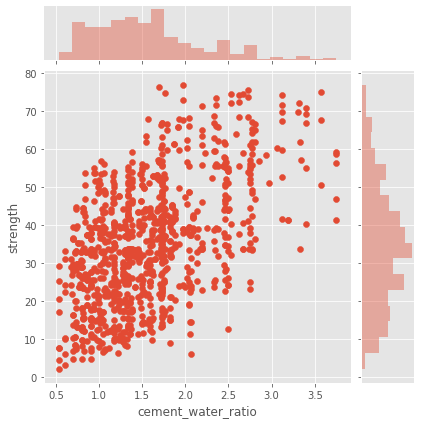

In [25]:
# Visualization of new variable with target variable
sns.jointplot(df_mod['cement_water_ratio'],df_mod['strength'])

### Observation for newly added feature 'cement_water_ratio':
* As seen above, cement_water_ratio has very good correlation (0.53) with strength and this can be really useful.

df_mod will be used as data model now onwards as it contains newly added feature 'cement_water_ratio'.

* As seen here, 'strength' is very non linear with most of it's features. This simple linear model won't work here. Now to get better modeling accuracy we need to use higher degree model here, wither quadratic or polynomial. This would help us to solve non linear behavior between 'strength' and otherindependent features.

* Hence, Polynomial features with degree 2 will be added here.

## Creating model and tuning it

In [26]:
ply = PolynomialFeatures(degree=2, interaction_only=True)
ply_fit = ply.fit_transform(df_mod.drop('strength', axis=1))
df_ply = pd.DataFrame(ply_fit,columns=['ft_'+str(i) for i in range(ply_fit.shape[1])])
df_ply.head()

,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,ft_18,ft_19,ft_20,ft_21,ft_22,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32,ft_33,ft_34,ft_35,ft_36,ft_37,ft_38,ft_39,ft_40,ft_41,ft_42,ft_43,ft_44,ft_45
0,1.00,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28.00,0.69,"29,955.60",0.00,"28,754.55",0.00,"137,315.34","105,763.05","3,956.40",98.11,0.00,"43,142.00",0.00,"206,021.60","158,682.00","5,936.00",147.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"197,761.30","152,319.75","5,698.00",141.30,0.00,0.00,0.00,0.00,"727,392.30","27,210.40",674.77,"20,958.00",519.72,19.44
1,1.00,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14.00,1.07,"7,127.58","20,994.27","26,736.87","1,824.12","182,547.12","134,478.18","2,364.60",180.21,"5,245.46","6,680.26",455.76,"45,609.76","33,599.64",590.80,45.03,"19,676.69","1,342.44","134,343.44","98,967.66","1,740.20",132.62,"1,709.64","171,090.64","126,038.46","2,216.20",168.90,"11,672.64","8,598.96",151.20,11.52,"860,532.96","15,131.20","1,153.17","11,146.80",849.51,14.94
2,1.00,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28.00,1.33,0.00,"23,925.00","46,850.00","1,375.00","239,225.00","215,300.00","7,000.00",333.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"17,934.18",526.35,"91,575.33","82,416.84","2,679.60",127.67,"1,030.70","179,323.06","161,388.88","5,247.20",250.00,"5,262.95","4,736.60",154.00,7.34,"824,082.28","26,793.20","1,276.55","24,113.60","1,148.88",37.35
3,1.00,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28.00,1.17,"30,324.00",0.00,"60,648.00",0.00,"247,912.00","178,220.00","7,448.00",310.33,0.00,"25,992.00",0.00,"106,248.00","76,380.00","3,192.00",133.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"212,496.00","152,760.00","6,384.00",266.00,0.00,0.00,0.00,0.00,"624,440.00","26,096.00","1,087.33","18,760.00",781.67,32.67
4,1.00,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28.00,0.80,"28,390.32",0.00,"29,922.84","1,408.68","162,137.52","107,849.16","4,334.40",123.97,0.00,"35,451.22","1,668.94","192,093.16","127,774.78","5,135.20",146.87,0.00,0.00,0.00,0.00,0.00,0.00,"1,759.03","202,462.42","134,672.11","5,412.40",154.80,"9,531.34","6,339.97",254.80,7.29,"729,723.58","29,327.20",838.79,"19,507.60",557.94,22.42


In [27]:
df_proc = df_mod.drop('strength',axis=1).join(df_ply)
df_proc['strength'] = df_mod['strength']
df_proc.fillna(0,inplace=True)
print(df_proc.shape)
df_proc.head()

(1005, 56)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,cement_water_ratio,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,ft_18,ft_19,ft_20,ft_21,ft_22,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32,ft_33,ft_34,ft_35,ft_36,ft_37,ft_38,ft_39,ft_40,ft_41,ft_42,ft_43,ft_44,ft_45,strength
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,0.69,1.00,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28.00,0.69,"29,955.60",0.00,"28,754.55",0.00,"137,315.34","105,763.05","3,956.40",98.11,0.00,"43,142.00",0.00,"206,021.60","158,682.00","5,936.00",147.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"197,761.30","152,319.75","5,698.00",141.30,0.00,0.00,0.00,0.00,"727,392.30","27,210.40",674.77,"20,958.00",519.72,19.44,29.89
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,1.07,1.00,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14.00,1.07,"7,127.58","20,994.27","26,736.87","1,824.12","182,547.12","134,478.18","2,364.60",180.21,"5,245.46","6,680.26",455.76,"45,609.76","33,599.64",590.80,45.03,"19,676.69","1,342.44","134,343.44","98,967.66","1,740.20",132.62,"1,709.64","171,090.64","126,038.46","2,216.20",168.90,"11,672.64","8,598.96",151.20,11.52,"860,532.96","15,131.20","1,153.17","11,146.80",849.51,14.94,23.51
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,1.33,1.00,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28.00,1.33,0.00,"23,925.00","46,850.00","1,375.00","239,225.00","215,300.00","7,000.00",333.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"17,934.18",526.35,"91,575.33","82,416.84","2,679.60",127.67,"1,030.70","179,323.06","161,388.88","5,247.20",250.00,"5,262.95","4,736.60",154.00,7.34,"824,082.28","26,793.20","1,276.55","24,113.60","1,148.88",37.35,29.22
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,1.17,1.00,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28.00,1.17,"30,324.00",0.00,"60,648.00",0.00,"247,912.00","178,220.00","7,448.00",310.33,0.00,"25,992.00",0.00,"106,248.00","76,380.00","3,192.00",133.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"212,496.00","152,760.00","6,384.00",266.00,0.00,0.00,0.00,0.00,"624,440.00","26,096.00","1,087.33","18,760.00",781.67,32.67,45.85
4,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28,0.80,1.00,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28.00,0.80,"28,390.32",0.00,"29,922.84","1,408.68","162,137.52","107,849.16","4,334.40",123.97,0.00,"35,451.22","1,668.94","192,093.16","127,774.78","5,135.20",146.87,0.00,0.00,0.00,0.00,0.00,0.00,"1,759.03","202,462.42","134,672.11","5,412.40",154.80,"9,531.34","6,339.97",254.80,7.29,"729,723.58","29,327.20",838.79,"19,507.60",557.94,22.42,18.29


### Observations:
* As seen above, we are having 1005 data points and 56 columns where some of the columns are being addded by the polynomial features.

### Create Train/Test split


In [28]:
X = df_proc.drop('strength', axis=1)
y = df_proc['strength']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [29]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(df_proc)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(df_proc)) * 100))
print("")

69.95% data is in training set
30.05% data is in test set



### Lasso to determine useful features

In [30]:
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)

Lasso()

In [31]:
# Update the dataframe to have features selected by lasso
feat_lasso = X_train.columns[lasso_reg.coef_!=0].tolist()
print(f'Total selected features by lasso {len(feat_lasso)}')
print(f'Lasso Model: {lasso_reg.coef_}')

Total selected features by lasso 40
Lasso Model: [ 9.25675385e-02  5.85637714e-02  3.93039882e-02 -2.09624872e-01
  6.39623618e-02 -2.09023435e-02 -1.96729178e-02  2.97379329e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  3.52210846e-04
  1.94396072e-05 -6.12151498e-07 -5.77284886e-04 -7.31549511e-05
  2.07453032e-05 -4.62314458e-06 -3.32792245e-03  4.09265609e-05
 -3.46352146e-04 -7.46520535e-04 -2.13456671e-05  8.62494064e-05
  2.48883741e-04 -5.82992045e-02 -7.52994135e-04  2.92779595e-04
 -4.19513255e-05  2.01582656e-04 -5.55225967e-05 -0.00000000e+00
  4.76625395e-03  1.39702952e-04 -1.24352597e-05 -1.22127143e-03
 -0.00000000e+00  3.59104894e-04 -1.09932316e-03 -1.28047189e-03
 -0.00000000e+00 -2.75994198e-05  2.86299427e-04  8.24377211e-03
 -1.07036264e-04  3.69634830e-03 -0.00000000e+00]


In [32]:
print(lasso_reg.score(X_train, y_train))
print(lasso_reg.score(X_test, y_test))

0.6931846998203681
0.6540149265670004


### Ridge to determine useful features

In [33]:
ridge = Ridge(alpha=.3)
ridge.fit(X_train,y_train)
print ("Ridge model:", (ridge.coef_))

Ridge model: [ 1.01649313e-01  5.94877406e-02  3.34861783e-02 -2.15657950e-01
  1.67038780e-01 -1.98380169e-02 -1.86197184e-02  2.99254799e-01
 -1.81323059e+00 -2.51839073e+00 -1.69471556e-01 -3.76956715e-01
 -7.74255317e-01 -4.10374009e-01  3.17300265e+00 -4.08343620e-02
  2.95368687e-01 -2.08278113e-01 -1.72981429e+00  3.21003553e-04
 -4.86423440e-04  1.39235687e-03  1.14204753e-02 -5.00350393e-04
  4.63802152e-04  2.76627555e-04 -2.14700176e-03  1.50272597e-04
  6.53782059e-04  1.40881075e-03  4.80622379e-05  2.26936942e-04
  3.79884654e-04 -4.82915359e-02  1.79729671e-03  4.28744231e-03
  8.76845327e-05  4.04208080e-04  1.68219166e-04  9.36242769e-02
 -1.26887498e-02  9.73032380e-04 -9.50093312e-04 -1.25350972e-03
 -1.69471556e-01  4.38793199e-04 -2.55548481e-03 -2.76380080e-03
 -1.76257292e+00 -1.88193348e-04  3.51263113e-04  8.76430074e-02
  1.86224647e-05 -6.06683285e-02 -2.61514679e-02]


In [34]:
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

0.6988045267822965
0.6497392134946622


## Regressor with popeline to test with kFold cross validation and compare the scores

### Following regressor will be applied
* Linear Regression
* Decision Tree Regressor
* Bagging Regressor
* RandomForest Regressor
* Adaboost Regression
* Gradient Boost Regressor

Here, we will be using df_mod to generate models that has newly added feature 'cement_water_ratio'.

In [35]:
print(df_mod.shape)
df_mod.head()

(1005, 10)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,cement_water_ratio
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89,0.69
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,23.51,1.07
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22,1.33
3,266.00,114.00,0.00,228.00,0.00,932.00,670.00,28,45.85,1.17
4,154.80,183.40,0.00,193.30,9.10,"1,047.40",696.70,28,18.29,0.80


Here, we got 10 columns with 1005 data points.

In [36]:
# Split the data to be given to the models
X=df_mod.drop('strength', axis=1)
y=df_mod['strength']
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
X_train.shape

(703, 9)

In [37]:
# Create pipelines for the models we have denoted above.
pipelines=[]
pipelines.append(('Linear Regression',Pipeline([('scaler',RobustScaler()),('linreg',LinearRegression())])))
pipelines.append(('DecisionTreeRegressor',Pipeline([('scaler',RobustScaler()),('dt',DecisionTreeRegressor())])))
pipelines.append(('BaggingRegressor',Pipeline([('scaler',RobustScaler()),('bgr',BaggingRegressor())])))
pipelines.append(('RandomForestRegressor',Pipeline([('scaler',RobustScaler()),('rft',RandomForestRegressor())])))
pipelines.append(('AdaboostRegressor',Pipeline([('scaler',RobustScaler()),('adb',AdaBoostRegressor())])))
pipelines.append(('GradientBoostRegressor',Pipeline([('scaler',RobustScaler()),('gdb',GradientBoostingRegressor())])))

# Create one data frame to store the refressors outcome.
df_outcome_train=pd.DataFrame({'Regressor':[],'Variance_Score_Train':[],'Standard Deviation':[],'95%_low':[],'95%_high':[]})
for idx, value in enumerate(pipelines):
    name,pipe=value
    kfold=KFold(n_splits=NUM_FOLDS,random_state=SEED)
    cv_outcome_train=cross_val_score(pipe,X,y,cv=kfold,scoring='explained_variance')
    df_outcome_train.loc[idx] = [name,cv_outcome_train.mean()*100,cv_outcome_train.std()*100, 
                                    cv_outcome_train.mean()*100-1.96*cv_outcome_train.std()*100, cv_outcome_train.mean()*100+1.96*cv_outcome_train.std()*100]
    
print("Cross-Validation results for Training data:")
print("")
df_outcome_train

Cross-Validation results for Training data:



,Regressor,Variance_Score_Train,Standard Deviation,95%_low,95%_high
0,Linear Regression,66.23,6.04,54.40,78.07
1,DecisionTreeRegressor,80.22,5.23,69.97,90.46
2,BaggingRegressor,86.22,4.30,77.79,94.65
3,RandomForestRegressor,87.51,3.98,79.71,95.31
4,AdaboostRegressor,73.45,3.73,66.14,80.77
5,GradientBoostRegressor,86.27,3.63,79.16,93.37


In [38]:
# Test score dataframe
df_outcome_test = pd.DataFrame({'Regressor':[],'Expl_VarianceScore_Test':[], 'R2_score_Test':[]})
for idx, value in enumerate(pipelines):
    # unpack the val
    name, pipe = value
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    df_outcome_test.loc[idx] = [name,explained_variance_score(y_test,y_pred)*100, r2_score(y_test, y_pred)]
# Let's check the test results with raw features  as well as new features
df_outcome_test

,Regressor,Expl_VarianceScore_Test,R2_score_Test
0,Linear Regression,66.06,0.66
1,DecisionTreeRegressor,77.52,0.77
2,BaggingRegressor,83.46,0.83
3,RandomForestRegressor,86.34,0.86
4,AdaboostRegressor,75.16,0.74
5,GradientBoostRegressor,84.84,0.85


### Feature importance given by ensemble model

In [39]:
# Train/Test splitR
X = df_mod.drop('strength',axis=1)
y = df_mod['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

# pipelines for 3 models.
pipe_rft = Pipeline([('scaler',RobustScaler()),('rft',RandomForestRegressor())])
pipe_bgr = Pipeline([('scaler',RobustScaler()),('bgr',BaggingRegressor())])
pipe_gdb = Pipeline([('scaler',RobustScaler()),('gdb',GradientBoostingRegressor())])

# Data Frame
df_importance_rft = df_importance_bgr = df_importance_gdb = pd.DataFrame({'Features':[], 'Importance':[]})

In [40]:
# Random Forest
pipe_rft.fit(X_train,y_train)
feat_Imp_rf = pipe_rft.steps[1][1].feature_importances_
df_importance_rft['Features'] = X_train.columns
df_importance_rft['Importance'] = feat_Imp_rf

# Feature importance given by Random Forest Regressor
df_importance_rft.sort_values(by='Importance', ascending=False)

,Features,Importance
8,cement_water_ratio,0.34
7,age,0.34
1,slag,0.09
3,water,0.06
0,cement,0.05
4,superplastic,0.04
6,fineagg,0.04
5,coarseagg,0.03
2,ash,0.01


In [41]:
# Bagging Regressor
pipe_bgr.fit(X_train,y_train)
feat_Imp_bgr = np.mean([tree.feature_importances_ for tree in pipe_bgr.steps[1][1].estimators_], axis=0)
df_importance_bgr['Features'] = X_train.columns
df_importance_bgr['Importance'] = feat_Imp_bgr

# Bagging Regressor
df_importance_bgr.sort_values(by='Importance', ascending=False)

,Features,Importance
8,cement_water_ratio,0.35
7,age,0.34
1,slag,0.09
3,water,0.06
0,cement,0.04
4,superplastic,0.04
6,fineagg,0.04
5,coarseagg,0.03
2,ash,0.01


In [42]:
# Gradient Boost Regressor
pipe_gdb.fit(X_train,y_train)
feat_Imp_gdb = pipe_gdb.steps[1][1].feature_importances_
df_importance_rft['Features'] = X_train.columns
df_importance_rft['Importance'] = feat_Imp_gdb

# Feature importance given by Gradient Boost Regressor
df_importance_gdb.sort_values(by='Importance', ascending=False)

,Features,Importance
7,age,0.38
8,cement_water_ratio,0.32
1,slag,0.10
3,water,0.06
0,cement,0.04
6,fineagg,0.04
4,superplastic,0.04
5,coarseagg,0.03
2,ash,0.00


### Observations and analysis for the algorithms used for this project

* As seen above, I have compared all the possible algorithms to match the requirement to fit the outcome with the non linear independent features.
* We can see that out of all the algorithms the ensemble ones are really useful to predict such outcome with non linearity attribute.
* Random Forest and Gradient boost performs much better after the feature engineering as compared to other regressors.
* Random Forest R2 score is already 86%
* Gradient Boost R2 score is also 85%.
* Out of all the features, the important features are 'age','cement_to_water_ratio' and 'slag'. These are the top 3 features affecting the outcome.

Let's apply the GridSearchCV and RandomSearchCV to find the best hyperparameters and see if we can improve the accuracy as well as R2 score.

### Techniques employed to squeeze that extra performance out of the model without making it over fit. Use Grid Search or Random Search on any of the two models used above. Make a DataFrame to compare models after hyperparameter tuning and their metrics as above. (15 marks)

### RandomizedSearchCV

#### Gradient boosting

In [43]:
# Here we will use Random Forest and Gradient Boosting model to test and compare hyperparameters. We will be using RandomSearchCV and GridSearchCV both to validate the best suitable hyperparametes.

# RandomizedSearchCV

#GradientBoosting
random_grid={'gdb__n_estimators':[100,500,1000], 
             'gdb__learning_rate': [0.1,0.05,0.02,0.01], 
             'gdb__max_depth':[4,6], 
             'gdb__min_samples_leaf':[3,5,9,17], 
             'gdb__max_features':[1.0,0.3,0.1] }
search = RandomizedSearchCV(estimator=pipe_gdb, param_distributions=random_grid, n_iter = 5, cv = kfold, scoring = 'explained_variance', n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter or CV score=%0.3f:" % search.best_score_)
print(search.best_params_)


Best parameter or CV score=0.891:
{'gdb__n_estimators': 1000, 'gdb__min_samples_leaf': 3, 'gdb__max_features': 0.1, 'gdb__max_depth': 6, 'gdb__learning_rate': 0.02}


In [44]:
y_pred_train = search.predict(X_train)
y_pred_test = search.predict(X_test)
from sklearn.metrics import explained_variance_score,r2_score
print('Testing Explained Variance Score is  {}'.format(explained_variance_score(y_test,y_pred_test)))
print('Testing R2 Score is  {}'.format(r2_score(y_test,y_pred_test)))

Testing Explained Variance Score is  0.8731888869526687
Testing R2 Score is  0.8714279528608881


#### RandomForestRegressor

In [45]:

random_grid=[{'rft__bootstrap': [True, False],
             'rft__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'rft__max_features': ['auto', 'sqrt'],
             'rft__min_samples_leaf': [1, 2, 4],
             'rft__min_samples_split': [2, 5, 10],
             'rft__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}]
search_rft = RandomizedSearchCV(estimator = pipe_rft, param_distributions = random_grid, n_iter = 5, cv = kfold, scoring = 'explained_variance', n_jobs = -1)

# Fit the random search model
search_rft.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('rft', RandomForestRegressor())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'rft__bootstrap': [True, False],
                                         'rft__max_depth': [10, 20, 30, 40, 50,
                                                            60, 70, 80, 90, 100,
                                                            None],
                                         'rft__max_features': ['auto', 'sqrt'],
                                         'rft__min_samples_leaf': [1, 2, 4],
                                         'rft__min_samples_split': [2, 5, 10],
                                         'rft__n_estimators': [200, 400, 600,
                                                               800, 1000, 1200,
                                    

In [46]:
y_pred_train = search_rft.predict(X_train)
y_pred_test = search_rft.predict(X_test)
from sklearn.metrics import explained_variance_score,r2_score
print('Testing Explained Variance Score is  {}'.format(explained_variance_score(y_test,y_pred_test)))
print('Testing R2 Score is  {}'.format(r2_score(y_test,y_pred_test)))

Testing Explained Variance Score is  0.8604934163471394
Testing R2 Score is  0.8598289619974591


### GridSearchCV

#### Gradient Boosting

In [47]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
X = df_mod.drop('strength',axis=1)
y = df_mod['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
pipe_gdb = Pipeline([('scaler',RobustScaler()),('gdb',GradientBoostingRegressor())])

In [48]:
pipe_gdb.steps[1][1].get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

* Above noted hyperparameters are available for the tuning.

In [49]:
param_grid=[{'gdb__n_estimators':[100,500,1000], 
             'gdb__learning_rate': [0.1,0.05,0.02,0.01], 
             'gdb__max_depth':[4,6], 
             'gdb__min_samples_leaf':[3,5,9,17], 
             'gdb__max_features':[1.0,0.3,0.1] }]

search_gdb = GridSearchCV(pipe_gdb, param_grid, cv = kfold, scoring = 'explained_variance', n_jobs=-1)
search_gdb.fit(X_train, y_train)
print("Best parameter or CV score=%0.3f:" % search_gdb.best_score_)
print(search_gdb.best_params_)

Best parameter or CV score=0.895:
{'gdb__learning_rate': 0.02, 'gdb__max_depth': 6, 'gdb__max_features': 0.3, 'gdb__min_samples_leaf': 5, 'gdb__n_estimators': 1000}


In [50]:
y_pred_train = search_gdb.predict(X_train)
y_pred_test = search_gdb.predict(X_test)
print('Testing Explained Variance Score is  {}'.format(explained_variance_score(y_test,y_pred_test)))
print('Testing R2 Score is  {}'.format(r2_score(y_test,y_pred_test)))

Testing Explained Variance Score is  0.8759227149054617
Testing R2 Score is  0.8742664618257914


### RadomForestRegressor -GridSearchCV

In [51]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
X = df_mod.drop('strength',axis=1)
y = df_mod['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
pipe_rft = Pipeline([('scaler',RobustScaler()),('rft',RandomForestRegressor())])

In [52]:
pipe_rft.steps[1][1].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [53]:
random_grid=[{'rft__bootstrap': [True, False],
             'rft__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
             'rft__max_features': ['auto', 'sqrt'],
             'rft__min_samples_leaf': [1, 2, 4],
             'rft__min_samples_split': [2, 5, 10],
             'rft__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}]

In [ ]:
search_rft = GridSearchCV(pipe_rft, random_grid, cv = kfold, scoring = 'explained_variance', n_jobs=-1)
search_rft.fit(X_train, y_train)
print("Best parameter or CV score=%0.3f:" % search_rft.best_score_)
print(search_rft.best_params_)

In [ ]:
y_pred_train = search_rft.predict(X_train)
y_pred_test = search_rft.predict(X_test)
print('Testing Explained Variance Score is  {}'.format(explained_variance_score(y_test,y_pred_test)))
print('Testing R2 Score is  {}'.format(r2_score(y_test,y_pred_test)))